## Boston Housing
*Виконала Сачек Владислава КА-31*
- Розглянуа задача регресії полягає у прогнозі медіанної вартості заселених будинків за набором ознак. Модель - **гребнева регресiя** з рiзними значеннями гiперпараметру alpha, використовуючи sklearn.linear_model.Ridge.

#### Імпорт бібліотек і завантаження даних
Оскільки load_boston() було видалено у нових версіях бібліотеки scikit-learn, завантажуємо з іншого ресурсу.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]
df = pd.DataFrame(data, columns=columns)
df["PRICE"] = target

print("Перші рядки датасету:")
print(df.head())

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/var/folders/s_/s1yw1h655b56tm0_tgzg96c40000gp/T/ipykernel_71575/3684921685.py:13: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


Перші рядки датасету:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


#### Візуалізації початкових даних

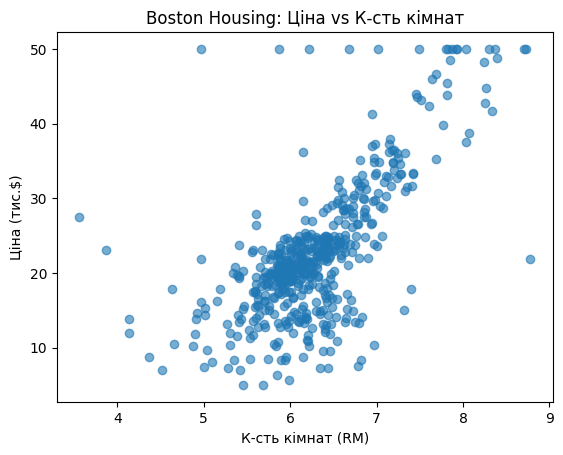

In [2]:
plt.scatter(df["RM"], df["PRICE"], alpha=0.6)
plt.xlabel("К-сть кімнат (RM)")
plt.ylabel("Ціна (тис.$)")
plt.title("Boston Housing: Ціна vs К-сть кімнат")
plt.show()

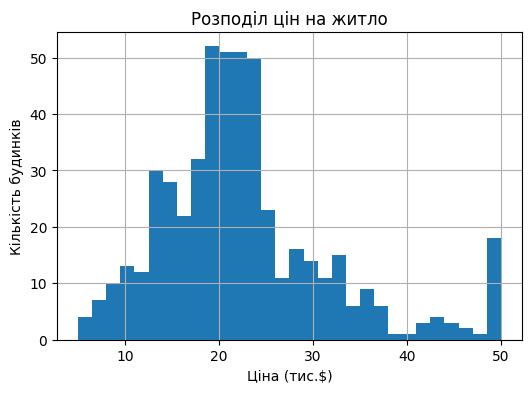

In [3]:
df["PRICE"].hist(bins=30, figsize=(6,4))
plt.xlabel("Ціна (тис.$)")
plt.ylabel("Кількість будинків")
plt.title("Розподіл цін на житло")
plt.show()

#### Розбиття початкових даних на навчальний та валідаційний набори
Частка прикладів у навчальному - 80%


In [4]:
X = df.drop("PRICE", axis=1)
y = df["PRICE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (404, 13)
Test size: (102, 13)


#### Масштабування
Гребнева регресія штрафує великі коефіцієнти для регуляризації лінійної регресії, тому для більш рівномірної регуляризації проведемо масштабування, тобто приведення всіх ознак до однакової шкали, з використанням методів *fit_transform()* (для навчального набору даних, рахує середнє і дисперсію) і *transform()* (для валідаційного набору, використовує середнє і дисперсію, пораховані на навчальному наборі) з бібліотеки scikit-learn:

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Побудова моделі для різних значень гіперпараметру alpha  
Візьмемо 9 значень коефцієнта регуляризації alpha від 10^-3 до 10^3, навчимо моделі гребневої регресії і виконаємо прогнози значень з використанням методів *fit()* та *predict()* з sklearn.linear_model.Ridge. Обчислимо для кожної моделі критерії якості $ R^2, RMSE, MAE, MAPE $ на обох наборах даних:

In [6]:
alphas = [1e-3,1e-2, 1, 3, 5, 10, 20, 100, 1000]
results = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    
    y_train_pred = ridge.predict(X_train_scaled)
    y_test_pred = ridge.predict(X_test_scaled)
    
    metrics = {
        "alpha": alpha,
        "R2_train": r2_score(y_train, y_train_pred),
        "R2_test": r2_score(y_test, y_test_pred),
        "RMSE_train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "RMSE_test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "MAE_train": mean_absolute_error(y_train, y_train_pred),
        "MAE_test": mean_absolute_error(y_test, y_test_pred),
        "MAPE_train": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        "MAPE_test": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    }
    results.append(metrics)

#### Оцінка якості моделей з різними alpha

In [7]:
res_df = pd.DataFrame(results)
print(res_df)

      alpha  R2_train   R2_test  RMSE_train  RMSE_test  MAE_train  MAE_test  \
0     0.001  0.750886  0.668759    4.652033   4.928604   3.314765  3.189088   
1     0.010  0.750886  0.668757    4.652033   4.928624   3.314710  3.189055   
2     1.000  0.750870  0.668462    4.652177   4.930812   3.308708  3.185724   
3     3.000  0.750761  0.667872    4.653201   4.935201   3.298794  3.181234   
4     5.000  0.750569  0.667297    4.654987   4.939469   3.291440  3.177851   
5    10.000  0.749854  0.665968    4.661659   4.949328   3.277318  3.172281   
6    20.000  0.747882  0.663794    4.679995   4.965403   3.262141  3.163073   
7   100.000  0.727140  0.654626    4.868708   5.032650   3.347353  3.174712   
8  1000.000  0.530442  0.529695    6.386870   5.872752   4.492725  3.925971   

   MAPE_train  MAPE_test  
0   16.574877  16.866382  
1   16.574537  16.866272  
2   16.537915  16.854676  
3   16.474883  16.838868  
4   16.424655  16.826306  
5   16.322950  16.801727  
6   16.193326  16.74

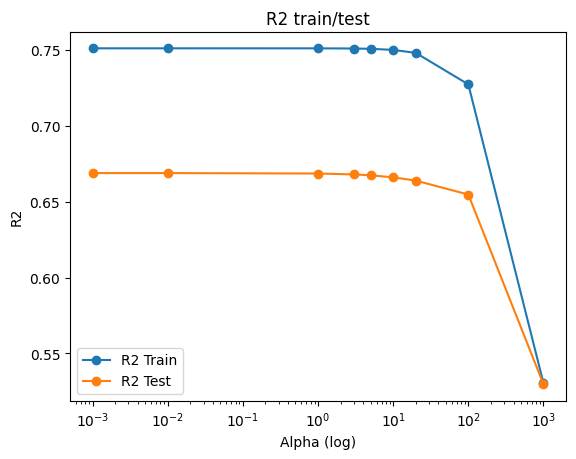

In [8]:
plt.plot(res_df["alpha"], res_df["R2_train"], "-o", label="R2 Train")
plt.plot(res_df["alpha"], res_df["R2_test"], "-o", label="R2 Test")
plt.xscale("log")
plt.xlabel("Alpha (log)")
plt.ylabel("R2")
plt.title("R2 train/test")
plt.legend()
plt.show()

> З отриманих результатів помітно, що зі зростанням значення коефіцієнта регуляризації alpha якість моделі погіршується на обох наборах даних, тобто надмірне збільшення штрафу призводить до недонавчання моделі. Найкращі результати досягаються при найменшому розглянутому alpha = 0.001: 
> - найбільше значення коефіцієнта детермінації $R^2$ = 0.6688 на тестовому наборі, що свідчить про те, що модель пояснює ~67% варіації залежної змінної;
> - найменше значення кореня середньоквадратичного відхилення RMSE = 4.9286;
> - середня абсолютна похибка MAE = 3.1891;
> - MAPE = 16.866%, тобто середнє відсоткове значення помилок близько 17%, модель відносно точна ;
> - значення метрик на навчальному і тестовому наборах залишаються достатньо близькими, тобто **модель не є перенавченою**.

#### Графік фактичних проти прогнозованих значень
Оберемо найкращий і найгірший гіперпараметр alpha за значенням $RMSE$, побудуємо модель гребневої регресії з цим значенням:

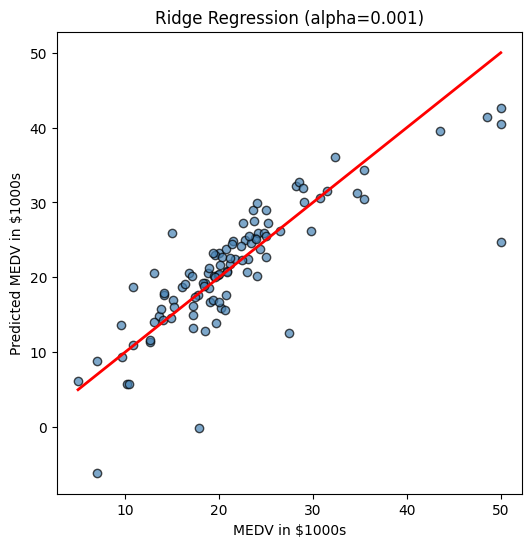

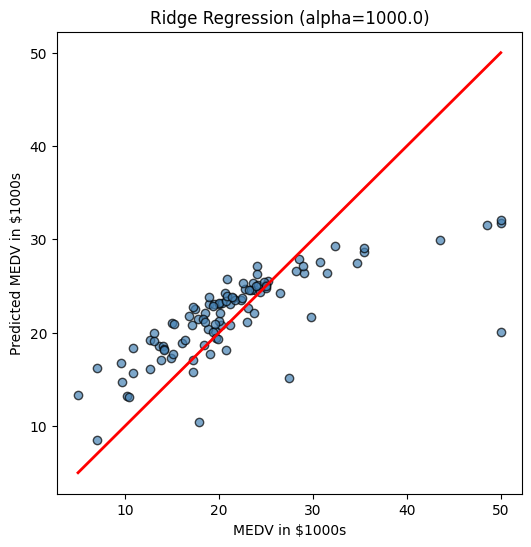

In [9]:
best_alpha = res_df.loc[res_df["RMSE_test"].idxmin(), "alpha"]
worst_alpha = res_df.loc[res_df["RMSE_test"].idxmax(), "alpha"]
alphas_min_max=[best_alpha, worst_alpha]

for alpha in alphas_min_max:
    ridge_a = Ridge(alpha=alpha) 
    ridge_a.fit(X_train_scaled, y_train)
    y_pred = ridge_a.predict(X_test_scaled)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color="steelblue", edgecolor="k")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linewidth=2)
    plt.xlabel("MEDV in $1000s")
    plt.ylabel("Predicted MEDV in $1000s")
    plt.title(f"Ridge Regression (alpha={alpha})")
plt.show()

За графіком кращої моделі видно, що більшість точок розташовані на діагоналі або близько неї, тобто модель достатньо добре прогнозує дані.  

#### Решітчастий пошук для підбору гіперпараметру alpha

In [10]:
param_grid = {"alpha": np.logspace(-3, 3, 10)}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid, scoring="neg_mean_squared_error", cv=5)
grid.fit(X_train_scaled, y_train)

print("\nGridSearchCV best alpha:", grid.best_params_["alpha"])


GridSearchCV best alpha: 2.154434690031882


#### Графік фактичних проти прогнозованих значень для aplha за решітчастим пошуком

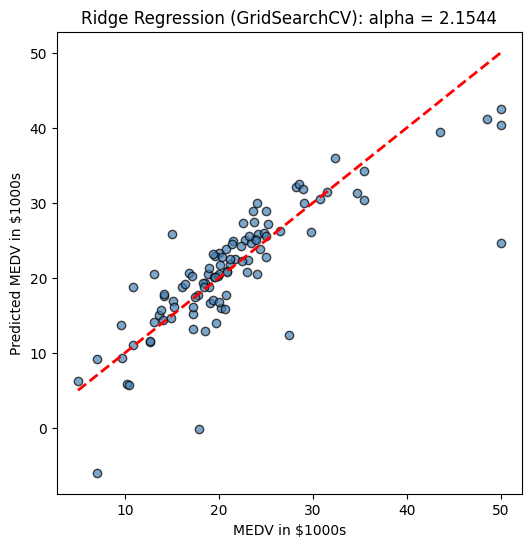

In [11]:
best_alpha_grid = grid.best_params_["alpha"]
best_ridge = Ridge(alpha=best_alpha_grid)
best_ridge.fit(X_train_scaled, y_train)

y_pred_grid = best_ridge.predict(X_test_scaled)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_grid, alpha=0.7, color="steelblue", edgecolor="k")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("MEDV in $1000s")
plt.ylabel("Predicted MEDV in $1000s")
plt.title(f"Ridge Regression (GridSearchCV): alpha = {best_alpha_grid:.4f}")
plt.show()

Оцінка критеріїв якості моделі:

In [12]:
print("R2_test:", r2_score(y_test, y_pred_grid))
print("RMSE_test:", np.sqrt(mean_squared_error(y_test, y_pred_grid)))
print("MAE_test:", mean_absolute_error(y_test, y_pred_grid))
print("MAPE_test:", np.mean(np.abs((y_test - y_pred_grid) / y_test)) * 100, "%")

R2_test: 0.6681202934807449
RMSE_test: 4.933355291603745
MAE_test: 3.182668828293339
MAPE_test: 16.843440947195205 %


GridSearchCV використовує усереднення результатів по 5 підмножинах, тому отриманий alpha забезпечує менший ризик перенавчання і краще узагальнення на нових даних.

#### Графік маргінального впливу ознаки RM на прогнозовану ціну
Зафіксуємо решту ознак на середніх значеннях і обчислимо прогноз зі зміною RM:

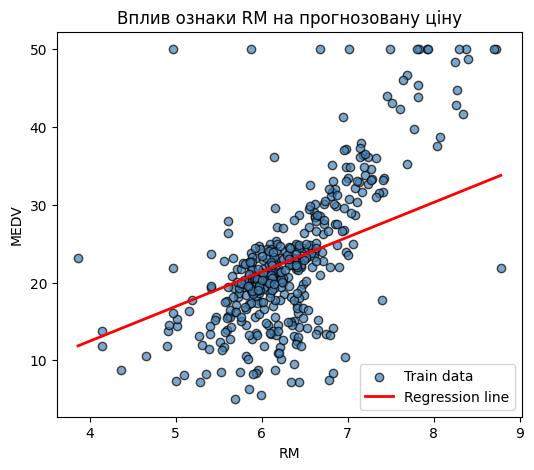

In [13]:
base_row = pd.DataFrame(X_train.mean()).T

rm_range = np.linspace(X_train["RM"].min(), X_train["RM"].max(), 100)
pred_rm = []
for val in rm_range:
    row = base_row.copy()
    row["RM"] = val
    row = row[X_train.columns]  
    pred_rm.append(best_ridge.predict(scaler.transform(row))[0])

plt.figure(figsize=(6, 5))
plt.scatter(X_train["RM"], y_train, alpha=0.7, color="steelblue", edgecolor="k", label="Train data")
plt.plot(rm_range, pred_rm, color="red", linewidth=2, label="Regression line")
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.title("Вплив ознаки RM на прогнозовану ціну")
plt.legend()
plt.show()

#### Оцінка впливу розміру навчальної множини на якість моделі за кривою навчання

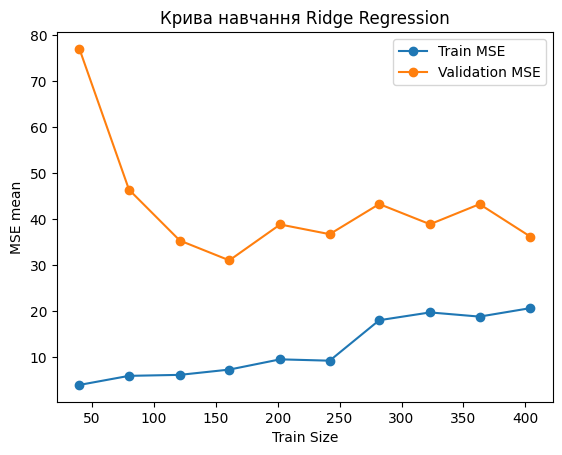

In [14]:
from sklearn.model_selection import learning_curve

X_scaled = scaler.fit_transform(X)
ridge = Ridge(alpha=grid.best_params_["alpha"])  

train_sizes, train_scores, val_scores = learning_curve(
    ridge,
    X_scaled,
    y,
    cv=5,              
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_mean = -train_scores.mean(axis=1)
val_mean = -val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, 'o-', label="Train MSE")
plt.plot(train_sizes, val_mean, 'o-', label="Validation MSE")
plt.title("Крива навчання Ridge Regression")
plt.xlabel("Train Size")
plt.ylabel("MSE mean")
plt.legend()
plt.show()


На малих train_size (10%) бачимо велику різницю між значеннями MSE на наборах: на великому тестовому ~ 80, а на малому навчальному близько нуля, тобто модель перенавчена. При збільшенні розміру навчальної вибірки помилка зростає на навчальній множині і знижується на тестовій, модель стає менш схильною до перенавчання і краще узагальнює закономірності. 